# For each constraint score, assess its performance on a stringent truth set

In [1]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})
plt.rc('font', family='arial')

In [2]:
import importlib
import matplotlib.cm as cm

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import util
importlib.reload(util)
from util import (
  length_to_string, 
  compute_limits as _compute_limits, 
  slice_feature_space,
)

In [3]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-labs/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

In [4]:
THRESHOLD_BIN_SIZE = 1000 # 4000, previously 

In [5]:
import polars as pl

def get_truth_set(): 
    df = pl.read_csv(
        f'{CONSTRAINT_TOOLS_DATA}/stringent_truth_set/truth-set.gnocchi.lambda_s.depletion_rank.CDTS.bed',
        separator='\t',
    )
    df = df.to_pandas()
    return df 
    
WINDOWS = get_truth_set()
WINDOWS

,chromosome,start,end,gnocchi,truly constrained,B,B_M1star.EUR,GC_content_1000bp,lambda_s,depletion_rank_constraint_score_complement,percentile_rank_of_observed_minus_expected_complement
0,chr1,2128961,2129161,6.530123,True,0.841,0.347981,0.585415,0.117883,0.899933,53.544438
1,chr1,2268561,2268761,5.007183,True,0.847,0.347981,0.602398,0.115906,0.600846,47.909374
2,chr1,6240740,6241540,3.309271,True,0.872,0.014875,0.548452,0.090827,0.879515,99.420742
3,chr1,6483340,6483540,3.687737,True,0.837,0.014875,0.572428,0.088351,0.832178,92.653453
4,chr1,6697340,6697540,1.642701,True,0.708,0.014875,0.461538,-0.008011,0.925050,99.234114
...,...,...,...,...,...,...,...,...,...,...,...
4928,chr6,46411000,46412000,0.025313,False,0.842,0.076253,0.363636,0.034791,0.726152,92.971132
4929,chr6,82997000,82998000,-0.291330,False,0.732,0.213906,0.387612,-0.033328,0.374379,56.933344
4930,chr1,30222000,30223000,0.489599,False,0.953,0.151525,0.446553,0.031316,0.782622,96.955803
4931,chr9,38203000,38204000,2.216012,False,0.782,0.681746,0.441558,0.254321,0.990101,66.855437


In [6]:
import pandas as pd

def downsample(df, group_columns, target):
  positive_class_sizes = df.groupby(group_columns)[target].apply(lambda ser: ser.value_counts().get(True, 0))
  negative_class_sizes = df.groupby(group_columns)[target].apply(lambda ser: ser.value_counts().get(False, 0))  
  positive_to_negative_ratios = positive_class_sizes/negative_class_sizes
  min_positive_to_negative_ratio = positive_to_negative_ratios.min()

  def downsample_positive_class(group):
    negative_class = group[group[target] == False]
    negative_class_size = len(negative_class)
    positive_class = group[group[target] == True]
    new_positive_class_size = int(min_positive_to_negative_ratio*negative_class_size)
    positive_class_downsampled = positive_class.sample(new_positive_class_size)
    return pd.concat([positive_class_downsampled, negative_class])
  
  df_downsampled = df.groupby(group_columns).apply(downsample_positive_class).reset_index(drop=True)
  return df_downsampled

def preprocess(df, feature, target, number_bins=None, bins=None): 
    df = df.copy() 

    if number_bins is None and bins is None: 
        raise ValueError('must provide only one of number_bins and bins')    
    if number_bins is not None: 
        df[f'{feature}_bin'] = pd.cut(df[f'{feature}'], bins=number_bins)
    elif bins is not None: 
        # https://pandas.pydata.org/docs/reference/api/pandas.cut.html
        df[f'{feature}_bin'] = pd.cut(df[f'{feature}'], bins) 
    else: 
        raise ValueError('must provide either bins or number_bins')

    df = downsample(
        df, 
        group_columns=[f'{feature}_bin'], 
        target=target
    )
    return df

def get_GC_mean_factor(gc_window_size): 
  if gc_window_size == 1000: 
    return 1
  elif gc_window_size == 1000000:
    return 0.975
  else:
    raise ValueError(f'invalid GC window size: {gc_window_size}')
                     
def get_GC_std_factor(gc_window_size): 
  if gc_window_size == 1000: 
    return 0.3
  elif gc_window_size == 1000000:
    return 0.3
  else:
    raise ValueError(f'invalid GC window size: {gc_window_size}')
  
def compute_center_limits(df, feature, mean_factor, std_factor):
  return _compute_limits(df, feature, mean_factor, std_factor)

def compute_GC_tail_limits(gc_window_size):
  if gc_window_size == 1000: 
    return 0.5, 1.0
  elif gc_window_size == 1000000:
    return 0.440, 1.0
  else:
    raise ValueError(f'invalid GC window size: {gc_window_size}')

def get_GC_feature_lims_label(df, gc_window_size): 
  return ( 
    f'GC_content_{gc_window_size}bp', 
    compute_center_limits(
      df, 
      f'GC_content_{gc_window_size}bp', 
      mean_factor=get_GC_mean_factor(gc_window_size), 
      std_factor=get_GC_std_factor(gc_window_size)
    ), 
    compute_GC_tail_limits(gc_window_size),
    f'GC_content ({length_to_string(gc_window_size)})'
  )

def get_features_and_lims_and_labels(df, gc_window_size, log=False): 
  features_and_lims_and_labels = [
    get_GC_feature_lims_label(df, gc_window_size),
    (
      'B_M1star.EUR', 
      compute_center_limits(
        df, 
        'B_M1star.EUR', 
        mean_factor=1, 
        std_factor=0.3
      ), 
      (0.75, 1.5),
      'gBGC'
    ),
    (
      'B', 
      compute_center_limits(
        df, 
        'B', 
        mean_factor=1, 
        std_factor=0.3
      ), 
      (0.5, 0.55),
      'BGS'
    ),
  ]

  if log: 
    for f, cl, _, _ in features_and_lims_and_labels: 
      print(f'{f}: {cl}')

  return features_and_lims_and_labels 

In [7]:
# this is "r" in the baseline-classifier theory: 
def compute_positive_fraction(df, target):
  value_counts = df[target].value_counts()
  number_negative_examples = value_counts.get(False, 0)
  number_positive_examples = value_counts.get(True, 0)
  return number_positive_examples / (number_negative_examples + number_positive_examples)

In [8]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

def plot_random_classifier(df, target, type_, color, ax):
    r = compute_positive_fraction(df, target)
    if type_ == 'precision': 
        ys = [r, r] 
    elif type_ == 'FDR':
        ys = [1-r, 1-r]
    else: 
        raise ValueError(f'invalid type: {type_}')
    ax.plot([0, 1], ys, linestyle='--', linewidth=3, color=color, label='random classifier') 
  
def plot_pr_curve_single_bin(ax, type_, precision, recall, feature, feature_bin, color):
    FDR = 1 - precision

    if type_ == 'precision': 
        ys = precision
    elif type_ == 'FDR':
        ys = FDR
    else:
        raise ValueError(f'invalid type: {type_}')
    
    ax.plot(recall, ys, color=color, linestyle='-', label=f'{feature} in {feature_bin}') 

def finish_pr_curve(ax, constraint_score_alias, facecolor_tuple): 
    ax.grid(False)
    ax.legend(facecolor='none')
    ax.set_xlabel('Recall')
    ylabel = 'Precision'
    ax.set_ylabel(ylabel) 
    ax.set_xlim(0, 1)
    ylim = (0, 1) 
    ax.set_ylim(ylim) # type: ignore
    ax.set_title(
        f'{constraint_score_alias}\n'
    )

def plot_curves_all_bins(df, type_, feature, number_bins, bins, constraint_score, constraint_score_alias, target, sliced): 
    df = preprocess(df, feature, target, number_bins, bins)

    _, ax_pr = plt.subplots(figsize=(10, 10))
    facecolor = 0.8
    facecolor_tuple = (facecolor, facecolor, facecolor)
    ax_pr.set_facecolor(facecolor_tuple)  # Set the background color of the axis to a lighter shade of grey

    cmap = cm.get_cmap('Blues') # , 'Greys', 'inferno' 

    list_of_dicts = []

    if number_bins is None and bins is None: 
        raise ValueError('must provide only one of number_bins and bins')    
    if number_bins is not None: 
        bins = df[f'{feature}_bin'].unique()
    elif bins is not None: 
        number_bins = len(bins)
    else: 
        raise ValueError('must provide either bins or number_bins')

    number_bins_to_plot = 0
    for i, feature_bin in enumerate(sorted(bins)): 
        df_bin = df[df[f'{feature}_bin'] == feature_bin]
        if len(df_bin) < THRESHOLD_BIN_SIZE: continue
        number_bins_to_plot += 1
    print(f'number_bins_to_plot: {number_bins_to_plot}')

    i = 0
    for feature_bin in sorted(bins): 
        df_bin = df[df[f'{feature}_bin'] == feature_bin]
        print(f'{feature_bin}: {len(df_bin)}')
        if len(df_bin) < THRESHOLD_BIN_SIZE: continue
        color = cmap(i / (number_bins_to_plot-1))
        i += 1
        targets, scores = df_bin[target], df_bin[constraint_score]        
        precision, recall, _ = precision_recall_curve(targets, scores)
        fpr, tpr, _ = roc_curve(targets, scores)
        list_of_dicts.append({
            'constraint_score': constraint_score_alias,
            'conditioned_on_complementary_features': sliced,
            'feature_to_stratify_by': feature,
            'feature_bin': feature_bin,
            'area': auc(recall, precision),
            'area_type': 'PRC',
            'area_color': color,
        })
        list_of_dicts.append({
            'constraint_score': constraint_score_alias,
            'conditioned_on_complementary_features': sliced,
            'feature_to_stratify_by': feature,
            'feature_bin': feature_bin,
            'area': auc(fpr, tpr),
            'area_type': 'ROC',
            'area_color': color,
        })
        list_of_dicts.append({
            'constraint_score': constraint_score_alias,
            'conditioned_on_complementary_features': sliced,
            'feature_to_stratify_by': feature,
            'feature_bin': feature_bin,
            'area': auc(recall, precision)/compute_positive_fraction(df_bin, target),
            'area_type': 'PRCnorm',
            'area_color': color,
        })
        plot_pr_curve_single_bin(ax_pr, type_, precision, recall, feature, feature_bin, color)

    plot_random_classifier(
        df, 
        target, 
        type_=type_,
        color='black', 
        ax=ax_pr,
    )

    # without breaking down by feature
    targets, scores = df[target], df[constraint_score]
    precision, recall, _ = precision_recall_curve(targets, scores)
    FDR = 1 - precision
    fpr, tpr, _ = roc_curve(targets, scores)

    list_of_dicts.append({
        'constraint_score': constraint_score_alias,
        'conditioned_on_complementary_features': sliced,
        'feature_to_stratify_by': feature,
        'feature_bin': 'all',
        'area': auc(recall, precision),
        'area_type': 'PRC',
        'area_color': 'green',
    })
    list_of_dicts.append({
        'constraint_score': constraint_score_alias,
        'conditioned_on_complementary_features': sliced,
        'feature_to_stratify_by': feature,
        'feature_bin': 'all',
        'area': auc(fpr, tpr),
        'area_type': 'ROC',
        'area_color': 'green',
    })
    list_of_dicts.append({
        'constraint_score': constraint_score_alias,
        'conditioned_on_complementary_features': sliced,
        'feature_to_stratify_by': feature,
        'feature_bin': 'all',
        'area': auc(recall, precision)/compute_positive_fraction(df, target),
        'area_type': 'PRCnorm',
        'area_color': 'green',
    })

    if type_ == 'precision': 
        ys = precision
    elif type_ == 'FDR':
        ys = FDR
    else:
        raise ValueError(f'invalid type: {type_}')
    ax_pr.plot(recall, ys, color='black', linewidth=3, linestyle='-', label=f'without breaking down by {feature}') 

    finish_pr_curve(ax_pr, constraint_score_alias, facecolor_tuple)

    plt.show()

    return list_of_dicts

def plot_curves_with_and_without_slicing(
    df, 
    gc_window_size, 
    feature, 
    number_bins, 
    bins,
    constraint_score, 
    constraint_score_alias,
    target, 
    type_='precision',
): 
    df = df.copy()
    assert feature in [f for f, _, _, _ in get_features_and_lims_and_labels(df, gc_window_size)]

    list_of_dicts = []
    list_of_dicts.extend(plot_curves_all_bins(df, type_, feature, number_bins, bins, constraint_score, constraint_score_alias, target, sliced=False))

    # conditional_features_and_center_lims = [
    #     (f, cl) for f, cl, _, _ in get_features_and_lims_and_labels(df, gc_window_size) if f != feature
    # ]
    # df_sliced = slice_feature_space(df, conditional_features_and_center_lims)
    # list_of_dicts.extend(plot_curves_all_bins(df_sliced, type_, feature, number_bins, bins, constraint_score, constraint_score_alias, target, sliced=True))

    return list_of_dicts

def compute_midpoints_and_positive_fraction(df, number_bins, bins, feature, target): 
    df = df.copy() 
    if number_bins is None and bins is None: 
        raise ValueError('must provide only one of number_bins and bins')    
    if number_bins is not None: 
        df[f'{feature}_bin'] = pd.cut(df[f'{feature}'], bins=number_bins)
    elif bins is not None: 
        # https://pandas.pydata.org/docs/reference/api/pandas.cut.html
        df[f'{feature}_bin'] = pd.cut(df[f'{feature}'], bins) 
    else: 
        raise ValueError('must provide either bins or number_bins')
    positive_fraction = df.groupby(f'{feature}_bin')[target].mean()
    bins = positive_fraction.index
    bins_series = pd.Series(bins)
    midpoints = bins_series.apply(lambda x: x.mid)
    return midpoints, positive_fraction

def compute_midpoints_and_positive_fraction_wrapper(conditioned_on_complementary_features, df, number_bins, bins, feature, target, gc_window_size): 
    if conditioned_on_complementary_features: 
        conditional_features_and_center_lims = [
            (f, cl) for f, cl, _, _ in get_features_and_lims_and_labels(df, gc_window_size) if f != feature
        ]
        df_sliced = slice_feature_space(df, conditional_features_and_center_lims)
        return compute_midpoints_and_positive_fraction(df_sliced, number_bins, bins, feature, target)    
    else: 
        return compute_midpoints_and_positive_fraction(df, number_bins, bins, feature, target)    

def line_plot(areas, windows, number_bins, bins, feature, target, gc_window_size):
    windows = windows.copy()
    x2_y2 = {}
    conditioned_on_complementary_features_values = [False]
    for conditioned_on_complementary_features in conditioned_on_complementary_features_values:
        x2_y2[conditioned_on_complementary_features] = compute_midpoints_and_positive_fraction_wrapper(
            conditioned_on_complementary_features=conditioned_on_complementary_features, 
            df=windows, 
            number_bins=number_bins, 
            bins=bins, 
            feature=feature, 
            target=target, 
            gc_window_size=gc_window_size
        )

    areas = areas[areas['feature_bin'] != 'all']
    for conditioned_on_complementary_features in conditioned_on_complementary_features_values:
        for area_type in ['PRCnorm', 'ROC']:
            areas_ = areas[
                (areas['conditioned_on_complementary_features'] == conditioned_on_complementary_features) &
                (areas['area_type'] == area_type)
            ]

            fig, axs = plt.subplots(2, 1, figsize=(10, 15), sharex=True)
            fig.subplots_adjust(hspace=0.1)

            constraint_scores = areas_['constraint_score'].unique()
            for constraint_score in constraint_scores:
                areas__ = areas_[areas_['constraint_score'] == constraint_score]
                x1 = areas__['feature_bin'].apply(lambda x: x.mid).astype(float)
                y1 = areas__['area']
                axs[0].plot(x1, y1, 'o-', label=constraint_score, linewidth=3)

            x2, y2 = x2_y2[conditioned_on_complementary_features]
            axs[1].plot(x2, y2, 'o-', linewidth=3)

            if area_type == 'PRCnorm':
                axs[0].axhline(y=1, color='black', linestyle='--', linewidth=3)
                axs[0].set_ylabel('auPRC (normalized by\npositive-class fraction)')
            elif area_type == 'ROC':
                axs[0].axhline(y=0.5, color='black', linestyle='--', linewidth=3)
                axs[0].set_ylabel('auROC')
            else: 
                raise ValueError(f'invalid area type: {area_type}')
            if conditioned_on_complementary_features:
                axs[0].set_title('conditioned on complementary features')
            else: 
                axs[0].set_title('not conditioned on complementary features')
            axs[0].legend(title='constraint score')
            
            axs[1].set_ylabel('Fraction of windows\nthat overlap essential enhancers')
            axs[1].set_ylim(0, 1)
            axs[1].set_xlabel(feature)

            plt.show()

def plot_area_under_curve_wrapper(gc_window_size, feature, number_bins=None, bins=None, target='truly constrained'): 
    list_of_dicts = []

    list_of_dicts.extend(plot_curves_with_and_without_slicing(
        WINDOWS,
        gc_window_size, 
        feature, 
        number_bins, 
        bins,
        constraint_score='gnocchi', 
        constraint_score_alias='gnocchi',
        target=target, 
    ))

    list_of_dicts.extend(plot_curves_with_and_without_slicing(
        WINDOWS, 
        gc_window_size, 
        feature, 
        number_bins, 
        bins,
        constraint_score='depletion_rank_constraint_score_complement',
        constraint_score_alias='depletion rank',
        target=target, 
    ))

    list_of_dicts.extend(plot_curves_with_and_without_slicing(
        WINDOWS, 
        gc_window_size, 
        feature, 
        number_bins, 
        bins,
        constraint_score='percentile_rank_of_observed_minus_expected_complement',
        constraint_score_alias='CDTS',
        target=target, 
    ))

    list_of_dicts.extend(plot_curves_with_and_without_slicing(
        WINDOWS, 
        gc_window_size, 
        feature, 
        number_bins, 
        bins,
        constraint_score='lambda_s',
        constraint_score_alias='lambda_s',
        target=target, 
    ))

    areas = pd.DataFrame(list_of_dicts)

    line_plot( 
        areas, 
        WINDOWS,
        number_bins, 
        bins, 
        feature, 
        target,
        gc_window_size
    )

number_bins_to_plot: 2
(0.2, 0.375]: 1579
(0.375, 0.6]: 2232


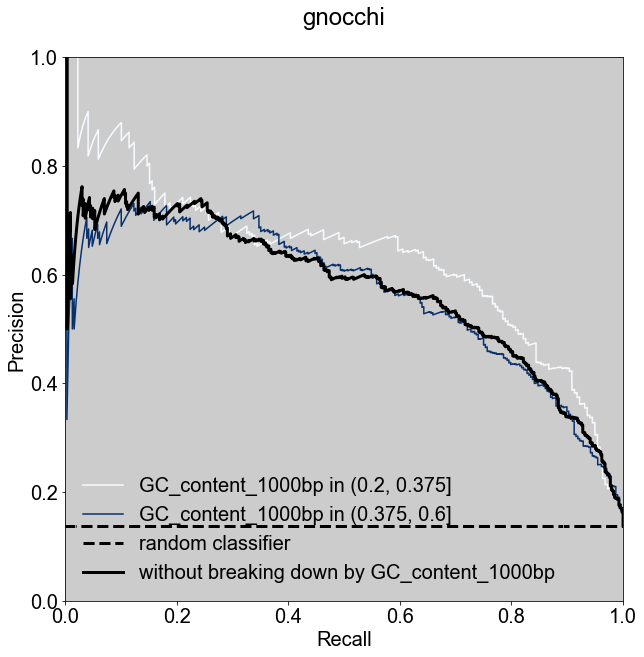

number_bins_to_plot: 2
(0.2, 0.375]: 1579
(0.375, 0.6]: 2232


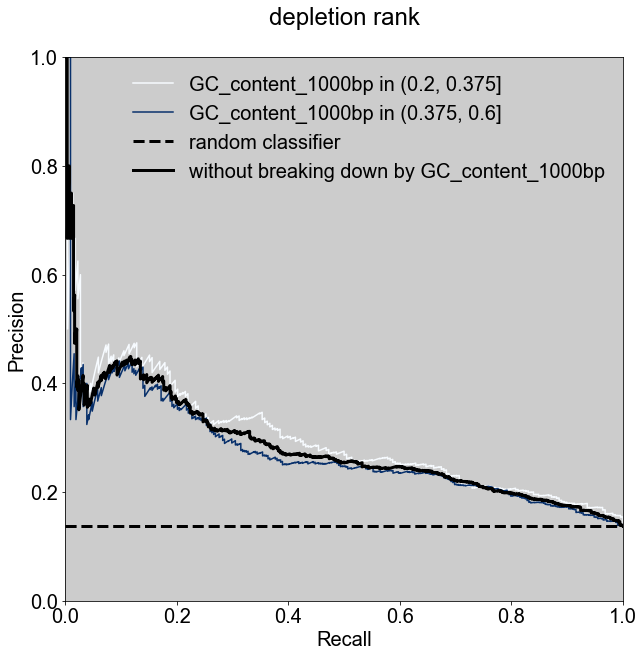

number_bins_to_plot: 2
(0.2, 0.375]: 1579
(0.375, 0.6]: 2232


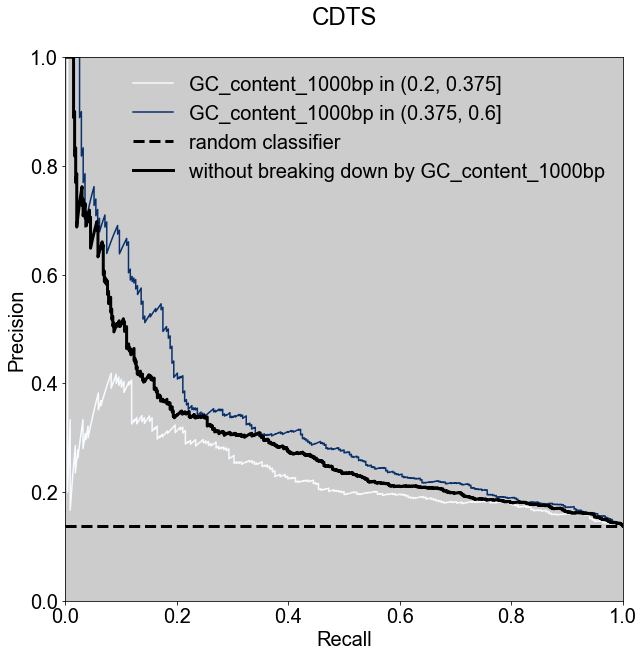

number_bins_to_plot: 2
(0.2, 0.375]: 1579
(0.375, 0.6]: 2232


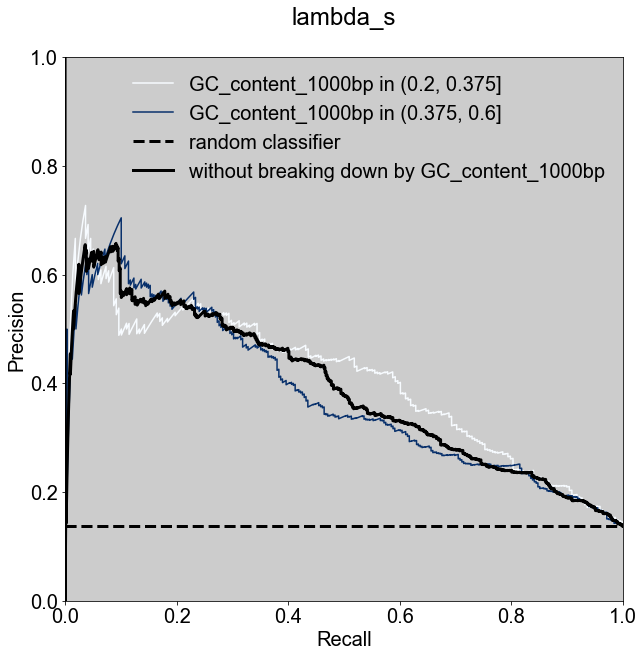

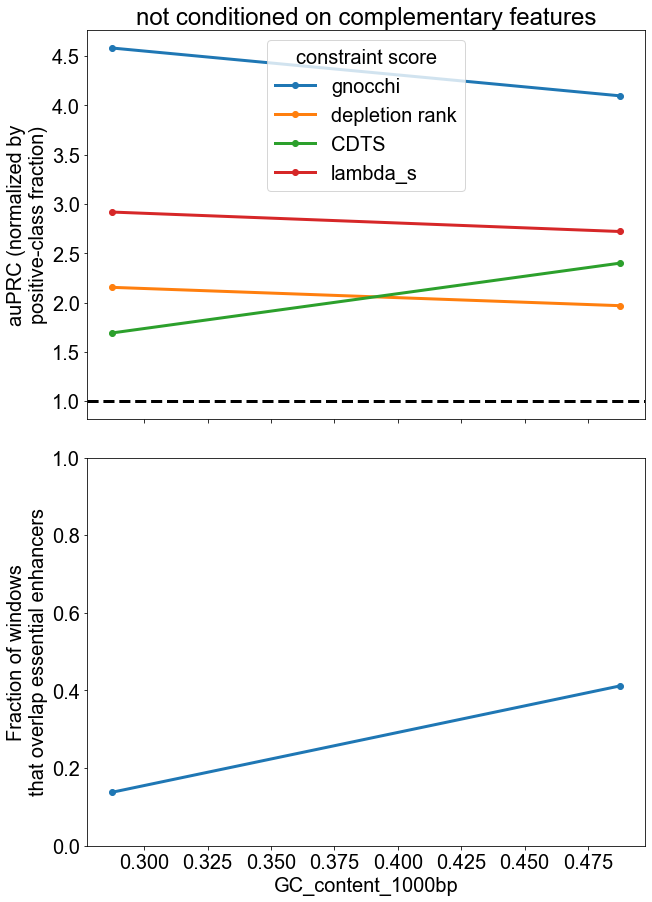

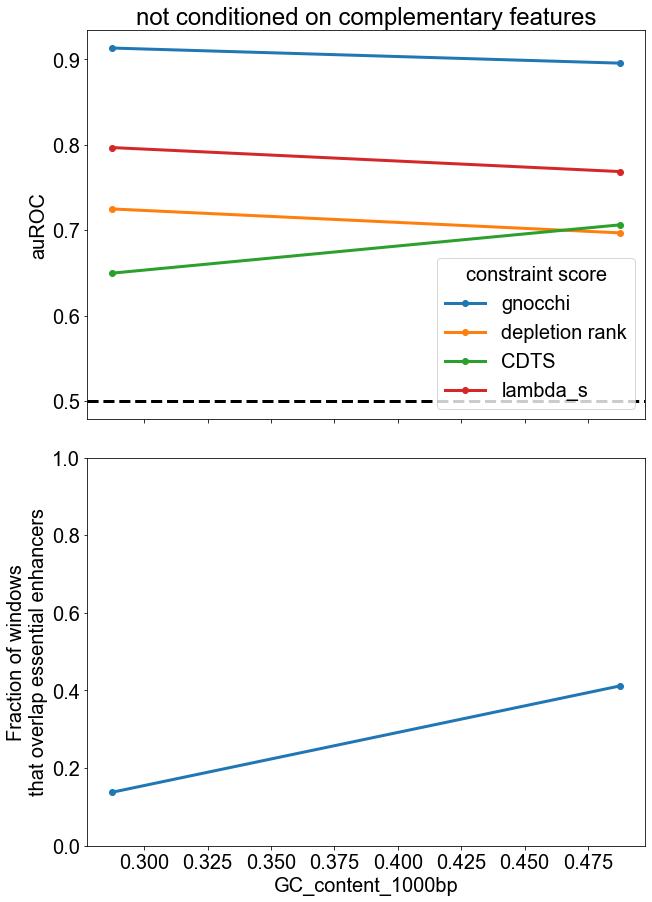

In [9]:
plot_area_under_curve_wrapper(
    gc_window_size=1000,
    feature='GC_content_1000bp',
    bins=pd.IntervalIndex.from_tuples([(0.2, 0.375), (0.375, 0.6)]), 
)

number_bins_to_plot: 3
(0.5, 0.76]: 1217
(0.76, 0.9]: 2040
(0.9, 1.0]: 1237


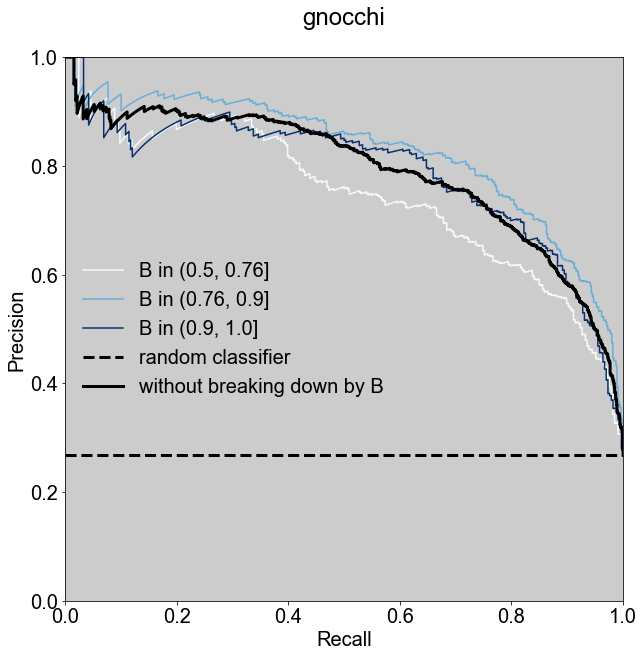

number_bins_to_plot: 3
(0.5, 0.76]: 1217
(0.76, 0.9]: 2040
(0.9, 1.0]: 1237


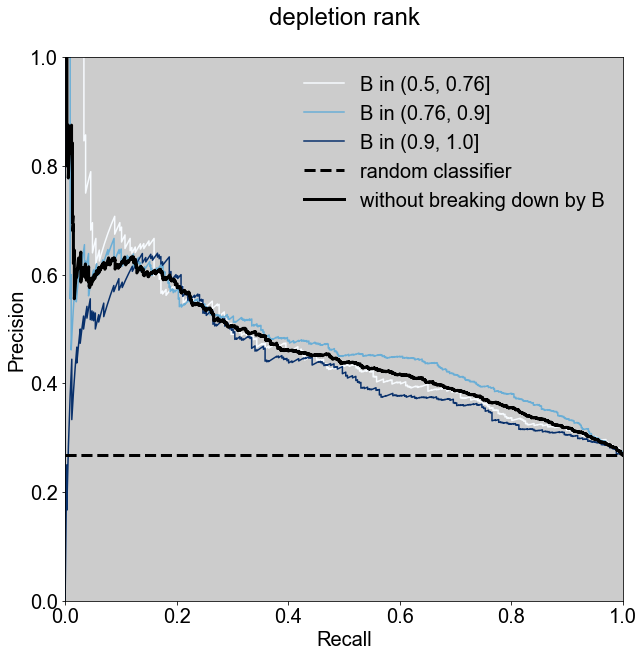

number_bins_to_plot: 3
(0.5, 0.76]: 1217
(0.76, 0.9]: 2040
(0.9, 1.0]: 1237


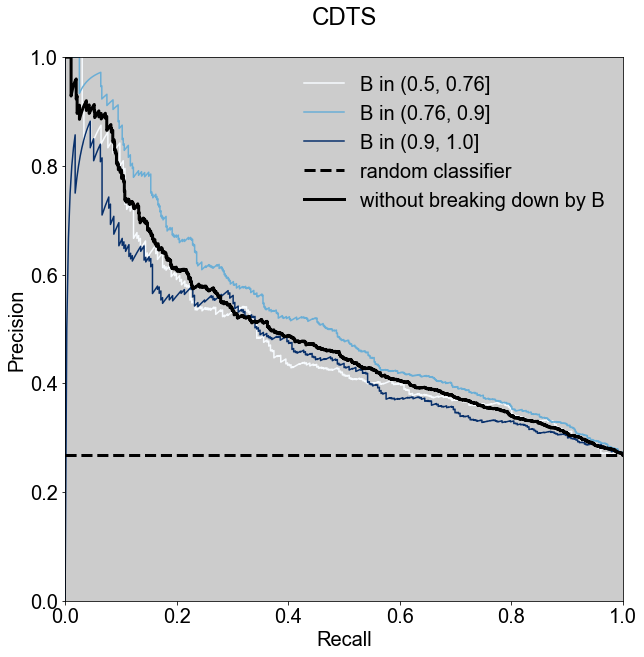

number_bins_to_plot: 3
(0.5, 0.76]: 1217
(0.76, 0.9]: 2040
(0.9, 1.0]: 1237


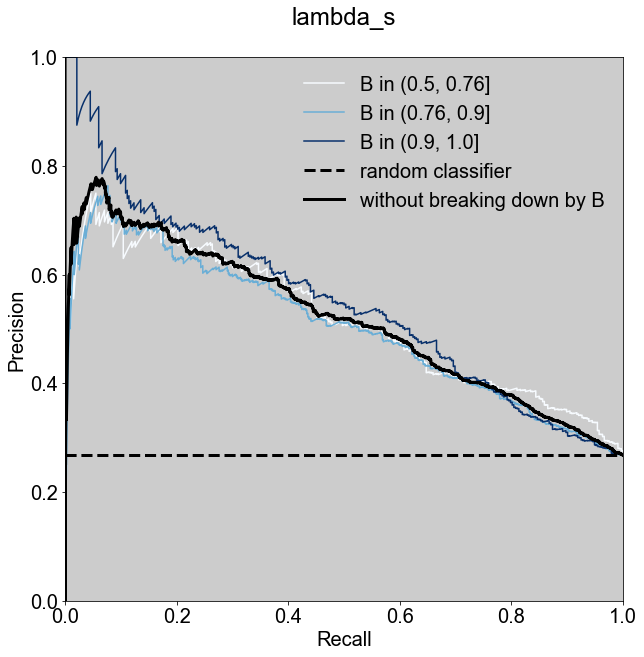

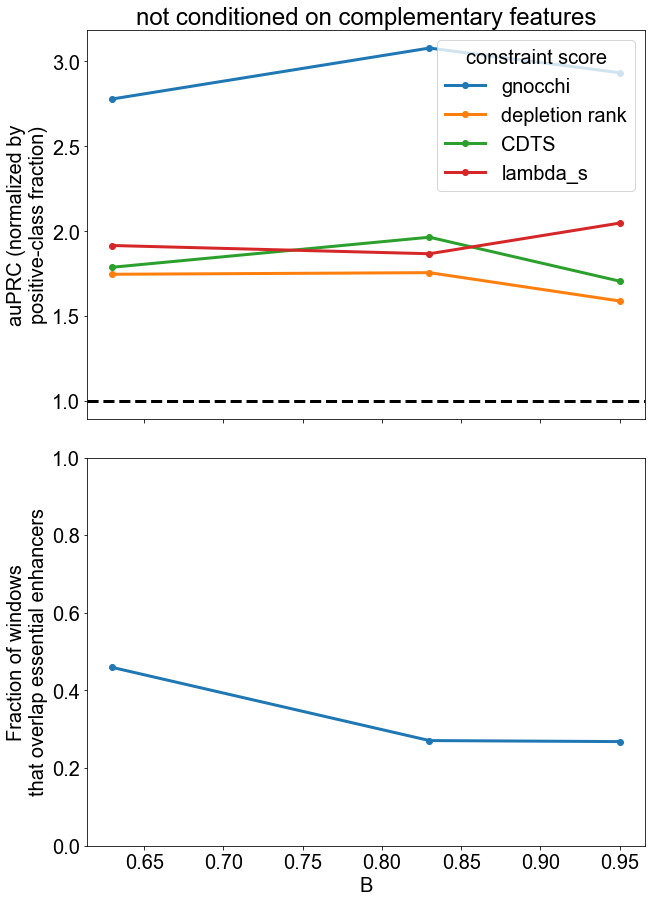

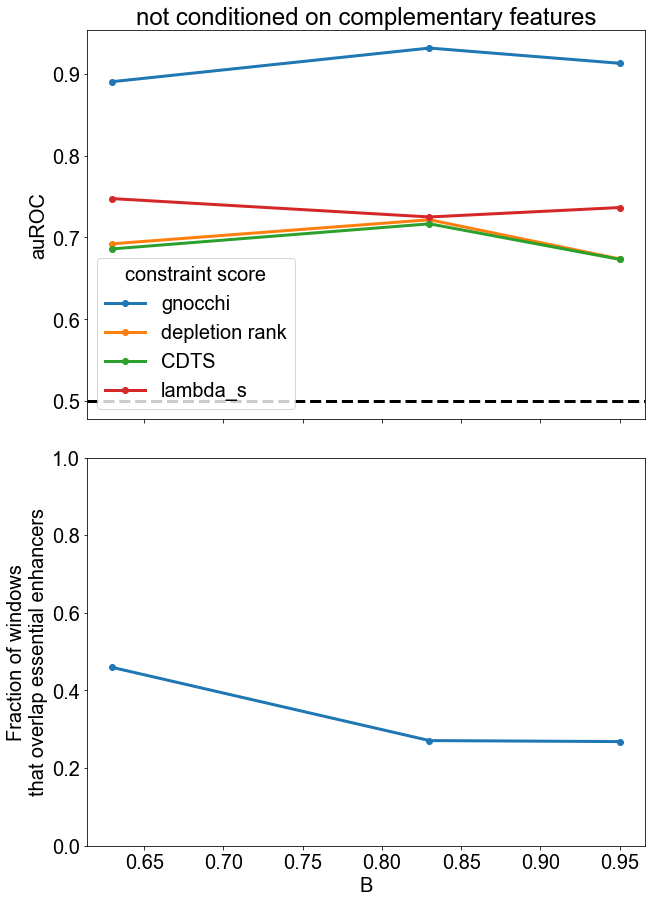

In [10]:
# c.f., experiments/germline-model/chen-et-al-2022/assess-impact-of-BGS-on-Gnocchi-predictions-at-labeled-enhancers.ipynb
plot_area_under_curve_wrapper(
    gc_window_size=1000,
    feature='B',
    bins=pd.IntervalIndex.from_tuples([(0.5, 0.76), (0.76, 0.9), (0.9, 1.0)]),
)

number_bins_to_plot: 3
(-0.3, 0.2]: 1717
(0.2, 0.4]: 1361
(0.4, 1.2]: 1530


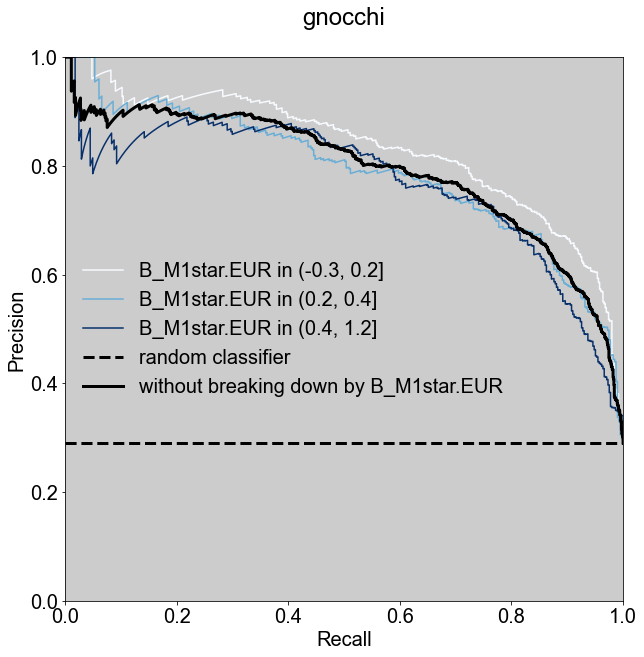

number_bins_to_plot: 3
(-0.3, 0.2]: 1717
(0.2, 0.4]: 1361
(0.4, 1.2]: 1530


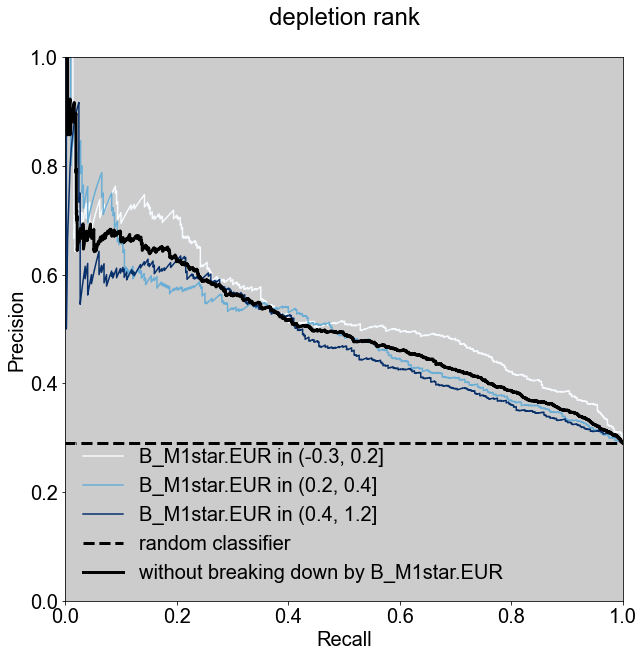

number_bins_to_plot: 3
(-0.3, 0.2]: 1717
(0.2, 0.4]: 1361
(0.4, 1.2]: 1530


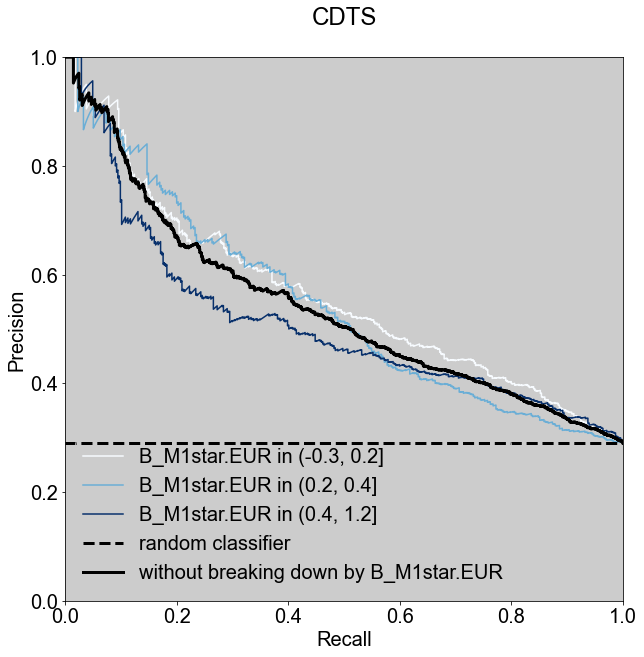

number_bins_to_plot: 3
(-0.3, 0.2]: 1717
(0.2, 0.4]: 1361
(0.4, 1.2]: 1530


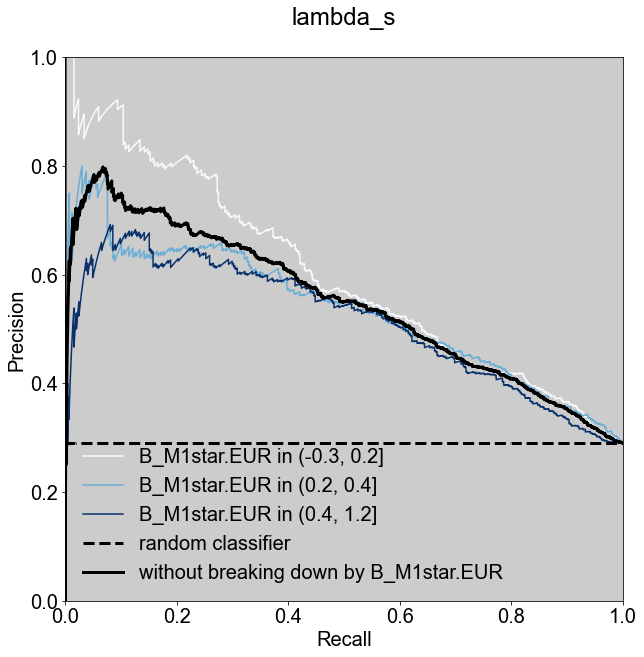

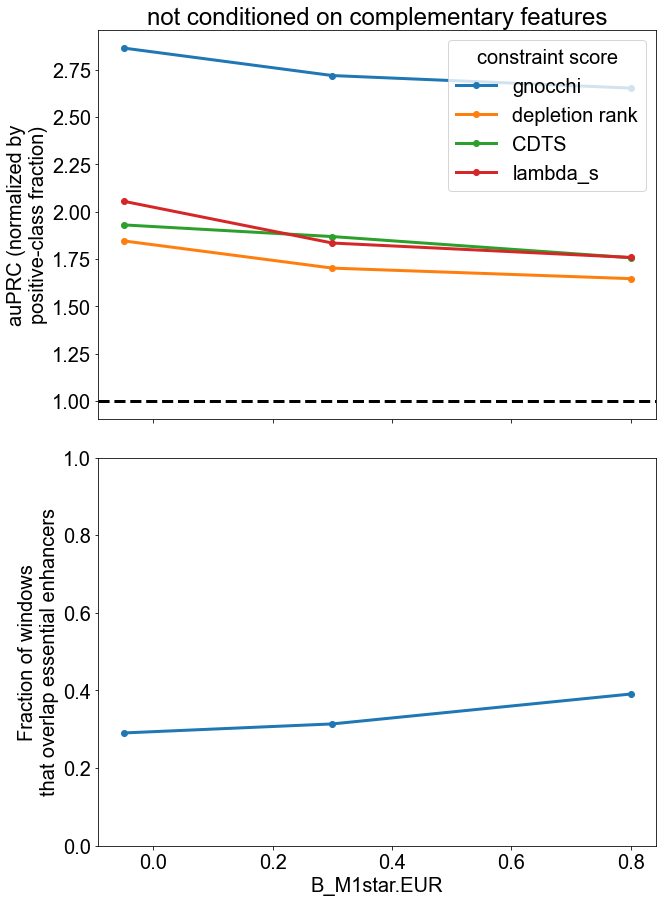

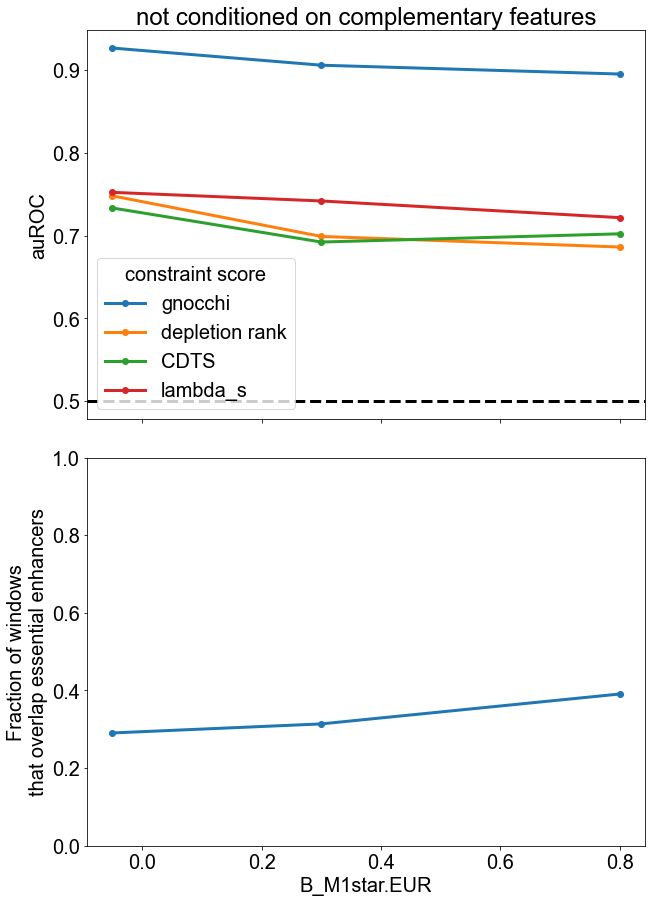

In [11]:
plot_area_under_curve_wrapper(
    gc_window_size=1000,
    feature='B_M1star.EUR',
    bins=pd.IntervalIndex.from_tuples([(-0.3, 0.2), (0.2, 0.4), (0.4, 1.2)]),
)